In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# stats = [(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)]
train_tfm = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                        tt.ToTensor() # tt.RandomHorizontalFlip()
                        ]) # tt.Normalize(*stats, inplace=True)
val_tfm = tt.ToTensor() # tt.Normalize(*stats)
val_ds = CIFAR100(
    root='./data', train=False, download=True, transform=val_tfm)
train_ds = CIFAR100(
    root='./data', train=True, download=True, transform=train_tfm)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
batch_size = 512
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [4]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

  
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  else:
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)
  
  def __len__(self):
    return len(self.dl)

In [5]:
def accuracy(output, label):
  _, pred = torch.max(output, dim=1)
  return torch.tensor(torch.sum(pred == label).item() / len(pred))

class CIFAR100ClassificationBase(nn.Module):

  def training_step(self, batch):
    image, label = batch
    out = self(image)
    loss = F.cross_entropy(out, label)
    acc = accuracy(out, label)
    return loss

  def validation_step(self, batch):
    image, label = batch
    out = self(image)
    loss = F.cross_entropy(out, label)
    acc = accuracy(out, label)
    return {'val_loss': loss.detach(), 'val_acc': acc}
  
  def validation_epoch_end(self, output):
    batch_losses = [x['val_loss'] for x in output]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in output]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  
  def epoch_end(self, epoch, result):
    print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lr'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [6]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool: 
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

In [7]:
class ResNet9(CIFAR100ClassificationBase):
  def __init__(self, in_channels, out_classes):
    super().__init__()

    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

    self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, out_classes))
    
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out

In [8]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)


def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader
                  , weight_decay, grad_clip=0, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []
  

  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  scheduled = torch.optim.lr_scheduler.OneCycleLR(
      optimizer, max_lr, epochs=epochs, steps_per_epoch = len(train_loader))
  

  for epoch in range(epochs):
    model.train()
    train_losses = []
    lrs = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
    
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
      
      optimizer.step()
      optimizer.zero_grad()

      lrs.append(get_lr(optimizer))
      scheduled.step()

    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lr'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [9]:
device = get_default_device()
model = to_device(ResNet9(3, 100), device)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 0.0001
opt_func = torch.optim.Adam

In [10]:
%%time
history = [evaluate(model, val_dl)]
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl
                         , grad_clip=grad_clip, weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.0015, train_loss: 4.0053, val_loss: 3.4011, val_acc: 0.1915
Epoch [1], last_lr: 0.0043, train_loss: 3.2758, val_loss: 3.2254, val_acc: 0.2391
Epoch [2], last_lr: 0.0076, train_loss: 2.7997, val_loss: 4.0388, val_acc: 0.1804
Epoch [3], last_lr: 0.0097, train_loss: 2.3280, val_loss: 3.0571, val_acc: 0.2920
Epoch [4], last_lr: 0.0099, train_loss: 1.9838, val_loss: 2.1217, val_acc: 0.4339
Epoch [5], last_lr: 0.0095, train_loss: 1.7323, val_loss: 1.9683, val_acc: 0.4630
Epoch [6], last_lr: 0.0087, train_loss: 1.5392, val_loss: 1.8702, val_acc: 0.5011
Epoch [7], last_lr: 0.0075, train_loss: 1.3948, val_loss: 1.7667, val_acc: 0.5238
Epoch [8], last_lr: 0.0061, train_loss: 1.2465, val_loss: 1.7282, val_acc: 0.5327
Epoch [9], last_lr: 0.0046, train_loss: 1.0826, val_loss: 1.6110, val_acc: 0.5716
Epoch [10], last_lr: 0.0032, train_loss: 0.8744, val_loss: 1.3758, val_acc: 0.6224
Epoch [11], last_lr: 0.0019, train_loss: 0.6656, val_loss: 1.2264, val_acc: 0.6694
Epoch [12], la

In [18]:
torch.save(model.state_dict(), 'CIFAR100_ResNet9_Adam.pth')

In [12]:
def loss_vs_epoch(history):
  train_ls = [result.get('train_loss') for result in history]
  val_ls = [result['val_loss'] for result in history]
  plt.plot(train_ls, '-ro')
  plt.plot(val_ls, '-bo')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'])
  plt.title('Loss vs Epoch')

In [13]:
def acc_vs_epoch(history):
  val_ac = [result['val_acc'] for result in history]
  plt.plot(val_ac, '-x')
  plt.xlabel('Accuracy')
  plt.ylabel('Epoch')
  plt.title('Accuracy vs Epoch')

In [14]:
def plot_lr(history):
  learning_rate = np.concatenate([result.get('lr', []) for result in history])
  plt.plot(learning_rate)
  plt.ylabel('Learning rate')
  plt.xlabel('Batch')
  plt.title('Learning Rate Curve')

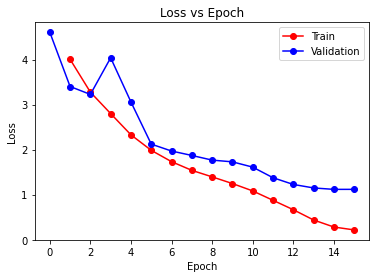

In [15]:
loss_vs_epoch(history)

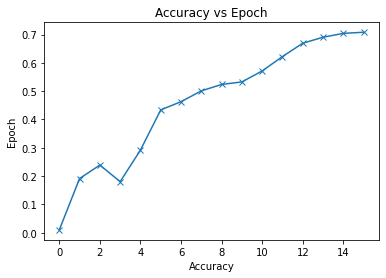

In [16]:
acc_vs_epoch(history)

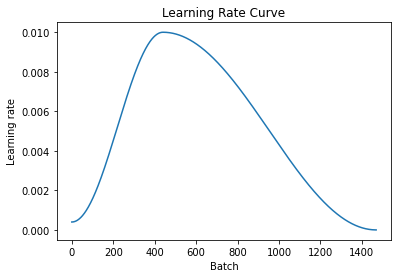

In [17]:
plot_lr(history)